In [4]:
#! pip install aeronet

import rasterio
from aeronet.dataset import Band
from aeronet.converters.split import split
import numpy as np
import argparse 
import rasterio

from aeronet.dataset import BandCollection, FeatureCollection, rasterize
from aeronet.converters.split import split
import torch
import matplotlib.pyplot as plt

## Rasterize vector images

In [15]:
for i in range(15):
    #  aeronet.dataset.transform. <rasterize/polygonize>
    num = i+1
    IMAGE_FILE = 'true_images/'+str(num)+'.tif'
    MASK_FILE = 'true_vector_masks/'+str(num)+'.geojson'
    OUT_PATH = 'true_rastr_masks2/'

    channels = ['RED'+str(num), 'GRN'+str(num), 'BLU'+str(num)]
    label = str(num)

    # split the multi-channel image to the separate files for each band
    # it saves the files to the filesystem and returns the BandCollection handle to them
    bc = split(IMAGE_FILE, OUT_PATH, channels)

    # Read the vector data
    fc = FeatureCollection.read(MASK_FILE)

    # The files can have different coordinate systems, so we will need to reproject vector data
    # crs is coordinate system feature for a georeferenced object
    fc = fc.reproject(dst_crs=bc.crs)

    # Now we can rasterize the map data, the mask will be saved in the same folder
    # the result is a BandSample of the size out_shape, with the given georeference and name

    mask_sample = rasterize(feature_collection=fc,
            transform=bc.transform,
            out_shape=bc[0].shape,
            name=label)

    # Now save it, the path is a folder to save, and the filename is derived from the BandSample name
    mask_sample.save(OUT_PATH)

## Cut image into 4 parts

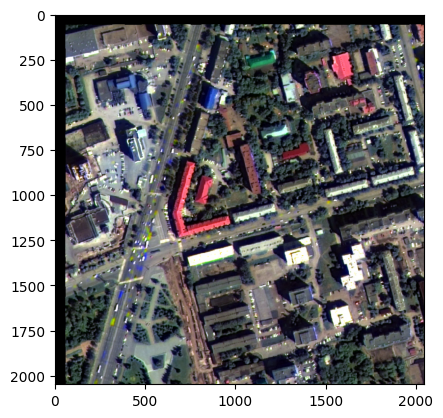

In [19]:

image = rasterio.open("true_images/1.tif")
x = image.read()
x = torch.tensor(x)
kernel_size, stride = 2048, 2048
patches = x.unfold(1, kernel_size, stride).unfold(2, kernel_size, stride)
patches = patches.contiguous().view(patches.size(0), -1, kernel_size, kernel_size)
patches = patches.swapaxes(0,1).swapaxes(1,3)
plt.imshow(patches[0])
plt.show()
#save_image(ToTensor()(patches[0]), DATASET_FOLDER + str(i+1) + '.tif')


## Convert to 8-bit image

In [ ]:
# Normalization parameter; change to 2 to make output more contrast
WIDTH = 3


def main(ms_file, out_file, r=1, g=2, b=3):
    print("Running image preprocessing script")
    with rasterio.open(ms_file) as src:
        profile = src.profile
        red = src.read(r)
        grn = src.read(g)
        blu = src.read(b)

    profile.update(count=3, dtype='uint8')
    
    # Nodata should be transfered to uint8 range to match the image dtype
    nodata_value = profile.get('nodata')
    if nodata_value is not None:
        if 0 <= nodata_value <= 255:
            profile.update(nodata=int(nodata_value))
        else:
            profile.update(nodata=0)

    channels_8bit = []
    for channel in [red, grn, blu]:
        mean, std, min_val, max_val = np.mean(channel), np.std(channel), np.min(channel), np.max(channel)
        m = max(min_val, mean - WIDTH*std)
        M = min(max_val, mean + WIDTH*std)
        ch_8bit = np.floor_divide(
            np.multiply((channel - m), 255, dtype='float32'),
            (M-m)
        )
        # We clip it from 1 to leave 0 value for nodata
        ch_8bit = np.clip(np.around(ch_8bit, 0), 1, 255).astype('uint8')
        channels_8bit.append(ch_8bit)

    with rasterio.open(out_file, 'w', **profile) as dst:
        dst.write(channels_8bit[0], 1)
        dst.write(channels_8bit[1], 2)
        dst.write(channels_8bit[2], 3)
    print('Done')

In [ ]:
x = np.arange(1,7)

for i in x:
    main('images_16_bit/' + str(i) + '.tif', 'images/' + str(i) + '.tif')